**Итоговое задание** 

Шишло Сергея по проекту 3 "О вкусной и здоровой пище" (DST-20).

Юнит 3. Введение в машинное обучение (последняя редакция 26.09.2020)

https://www.kaggle.com/sergejshishlo/notebook690511dfe4?scriptVersionId=43485033

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from IPython.display import display
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
from collections import Counter
import random
from sklearn.preprocessing import StandardScaler

In [2]:
RANDOM_SEED = 42
!pip freeze > requirements.txt
CURRENT_DATE = pd.to_datetime('21/09/2020')

In [3]:
def diagram_bar(data, column):
    fig = plt.figure()
    main_axes = fig.add_axes([0,0,1,1])
    data[column].hist(bins = 20)
    insert_axes = fig.add_axes([1.1,0,0.5,1])
    data.boxplot(column = column)
    

In [4]:
def hypothyroidism(data, column, alpha):
    if (st.ttest_ind(df[(df['Sample'] == 1) & df[column] == 1].Rating, df[(df['Sample'] == 1) & df[column] == 0].Rating).pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [5]:
def hypothyroidism_1(data, column, alpha):
    for row in combinations(data[column].unique(), 2):
        print(row)
        if (st.ttest_ind(data[(data['Sample'] == 1) & data[column] == row[0]].Rating, data[(df['Sample'] == 1) & data[column] == row[1]].Rating).pvalue < alpha):
            print("Отвергаем нулевую гипотезу равенства рейтингов ", row)
        else:
            print("Не получилось отвергнуть нулевую гипотезу равенства ", row)
    

Осуществим загрузку данных
------

In [6]:
path_to_file = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(path_to_file+'main_task.csv')
df_test = pd.read_csv(path_to_file+'kaggle_task.csv')
sample_submission = pd.read_csv(path_to_file+'/sample_submission.csv')
pd.set_option('display.max_columns', 200)
display(df_train.head(2))
display(df_test.head(2))

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944


In [7]:
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


None

Вывод
------

   1. Стоит обратить на большое количество пропусков в столбцах Cuisine Style, Price Range.
   2. Сложное заполнение данных в столбце Reviews там содержатся строковые данные и даты.

Предобработка данных
------

**Шаг 1. Проверим данные на дубликаты**

Для анализа будем использовать данные без учета отзывов

In [8]:
df_train.drop('Reviews', axis = 1).duplicated().sum()

0

In [9]:
df_test.drop('Reviews', axis = 1).duplicated().sum()

0

**Вывод**

Дубликаты отсутствуют как в обучающей так и в тестовой выборке

**Шаг 2.** Проанализируем значение целевой переменной на тесовой выборке

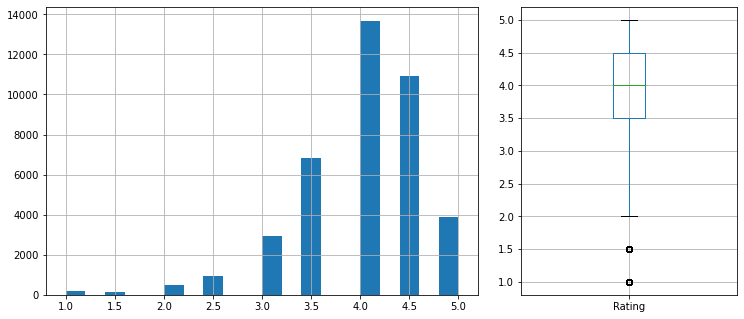

In [10]:
diagram_bar(df_train, 'Rating')

In [11]:
#q25, q75 = df_train['Rating'].quantile([0.25,0.75])
#IQR = q75 - q25
#df_train = df_train[df_train['Rating'] >= (q25 - 1.5*IQR)]
#df_train.info()                                           

**Вывод** 

Среди данных о рейтинге существуют выбросы по нижней границе. Данные от выбросов очищать не будем т.к. теряются уникальные значения.

**Шаг 3.** Соединение двух DF: обучающего и тренеровочного

In [12]:
df_train['Sample'] = 1 # метка для обучающей DF
df_test['Sample'] = 0 # метка для тестовой DF
df_test['Rating'] = 0 # т.к. в тестовой выборке отсутствует столбец Rating, то создаем и заполняем его столбец 0

df = df_test.append(df_train, sort=False).reset_index(drop=True) 

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   Sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


**Шаг 4.** Анализ DF по столбцам

**Restaurant_id**

Проанализируем данные столбца

In [14]:
len(df.Restaurant_id.value_counts())

13094

In [15]:
restaurant = df.Restaurant_id.value_counts().reset_index()
restaurant

,index,Restaurant_id
0,id_436,19
1,id_871,19
2,id_633,19
3,id_227,19
4,id_71,18
...,...,...
13089,id_9900,1
13090,id_13763,1
13091,id_7430,1
13092,id_5509,1


**Вывод**

Стоит обратить внимание, что данный столбик характерезует идентификационный номер ресторана / сети ресторанов. Из данного столбца сгенерируем новый признак сеть объектов общественного питания(1) или отдельный рестаран(0). 

In [16]:
restaurant = restaurant[restaurant.Restaurant_id > 1]
df['restaurant_chain'] = df['Restaurant_id'].where(df['Restaurant_id'].isin(restaurant['index']), 0)
df.loc[df.restaurant_chain != 0, 'restaurant_chain'] = 1

Проверим на статистическую значимость значение нового критерия

При определении соотвествия среднего значения рейтинга ресторана
   - H0 - средний рейтинг сетевых и несетевых заведений одинаковый
   - Н1 - средний рейтинг сетевых и несетевых заведений не равен
   - Пороговое значение alpha 5%

In [17]:
alpha = 0.05
if (st.ttest_ind(df[(df['Sample'] == 1) & df['restaurant_chain'] == 1].Rating, df[(df['Sample'] == 1) & df['restaurant_chain'] == 0].Rating).pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


**Вывод**

После анализа и обработки добавлен новый признак: относится ли ресторан к сети или нет. В новом признаке выбросов нет.

**City**

Проанализируем данные столбца

In [18]:
len(df['City'].value_counts())

31

In [19]:
# на города приходится 31 уникальное значение. Ранее сделанный анализ показал, 
# что сократить количество городов не имеет никакого смысла.
# Поэтому принял решения просто их закодировать

le = LabelEncoder()
le.fit(df['City'])
df['City_code'] = le.transform(df['City'])

**Вывод**

 Для составления более качественной модели прогноза, попробуем составить рейтинг исходя из трех новых признаков: 
   1. Столица / обычный город
   2. Размер населения населения
   3. Средний размер дохода .
   4. Страна нахождения города

**Генерируем новые признаки. **

2.1 Столица или не столица

In [20]:
dict_Сity_capital = {'London' : 1, 'Paris' : 1, 'Madrid' : 1, 'Barcelona' : 0, 
                        'Berlin' : 1, 'Milan' : 0, 'Rome' : 1, 'Prague' : 1, 
                        'Lisbon' : 1, 'Vienna' : 1, 'Amsterdam' : 1, 'Brussels' : 1, 
                        'Hamburg' : 0, 'Munich' : 0, 'Lyon' : 0, 'Stockholm' : 0, 
                        'Budapest' : 1, 'Warsaw' : 1, 'Dublin' : 1, 
                        'Copenhagen' : 1, 'Athens' : 1, 'Edinburgh' : 1, 
                        'Zurich' : 1, 'Oporto' : 0, 'Geneva' : 0, 'Krakow' : 0, 
                        'Oslo' : 1, 'Helsinki' : 1, 'Bratislava' : 1, 
                        'Luxembourg' : 1, 'Ljubljana' : 1}
df['capital'] = df.apply(lambda row: dict_Сity_capital[row['City']], axis = 1)

hypothyroidism(df, 'capital', 0.05)

Отвергаем нулевую гипотезу


**Вывод**

Фактор столица/не столица мы добавляем в будущую модель

In [21]:
dict_Сity_population= {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 
                        'Berlin' : 6010, 'Milan' : 1366, 'Rome' : 2872, 'Prague' : 1308, 
                        'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                        'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 
                        'Budapest' : 1752, 'Warsaw' : 1764, 'Dublin' : 553, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 415, 'Oporto' : 240, 'Geneva' : 201, 'Krakow' : 769, 
                        'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 119, 'Ljubljana' : 284}
df['Сity_population'] = df.apply(lambda row: dict_Сity_population[row['City']], axis = 1)

**Вывод**

Протестируем разные переменные в моделе 

2.2 Средний размер дохода

In [22]:
dict_Сity_income = {'London' : 2511, 'Paris' : 3617, 'Madrid' : 2651, 'Barcelona' : 2663, 
                        'Berlin' : 4521, 'Milan' : 3183, 'Rome' : 2843, 'Prague' : 1400, 
                        'Lisbon' : 1526, 'Vienna' : 2646, 'Amsterdam' : 4612, 'Brussels' : 3401, 
                        'Hamburg' : 5604, 'Munich' : 5181, 'Lyon' : 2400, 'Stockholm' : 2391, 
                        'Budapest' : 670, 'Warsaw' : 1259, 'Dublin' : 3000, 
                        'Copenhagen' : 5000, 'Athens' : 1100, 'Edinburgh' : 2050, 
                        'Zurich' : 6758, 'Oporto' : 1288, 'Geneva' : 2100, 'Krakow' : 1027, 
                        'Oslo' : 4048, 'Helsinki' : 3691, 'Bratislava' : 1176, 
                        'Luxembourg' : 5000, 'Ljubljana' : 1807}
df['Сity_income'] = df.apply(lambda row: dict_Сity_income[row['City']], axis = 1)

**Вывод**

Протестируем разные переменные в моделе 

Country

In [23]:
dict_Сountries = {'London' : 'England', 'Paris' : 'France', 'Madrid' : 'Spain', 
                  'Barcelona' : 'Spain', 'Berlin' : 'Germany', 'Milan' : 'Italy', 
                  'Rome' : 'Italy', 'Prague' : 'Czech_c', 'Lisbon' : 'Portugal', 
                  'Vienna' : 'Austria', 'Amsterdam' : 'Holland', 
                  'Brussels' : 'Belgium', 'Hamburg' : 'Germany', 'Munich' : 'Germany', 
                  'Lyon' : 'France', 'Stockholm' : 'Sweden', 'Budapest' : 'Romania', 
                  'Warsaw' : 'Poland', 'Dublin' : 'Ireland', 'Copenhagen' : 'Denmark', 
                  'Athens' : 'Greece', 'Edinburgh' : 'Scotland', 'Zurich' : 'Switzerland', 
                  'Oporto' : 'Portugal', 'Geneva' : 'Switzerland', 'Krakow' : 'Poland', 
                  'Oslo' : 'Norway', 'Helsinki' : 'Finland', 'Bratislava' : 'Slovakia', 
                  'Luxembourg' : 'Luxembourg_c', 'Ljubljana' : 'Slovenia'}
df['Сountry'] = df.apply(lambda row: dict_Сountries[row['City']], axis = 1)

le = LabelEncoder()
le.fit(df['Сountry'])
df['code_Сountry'] = le.transform(df['Сountry'])

**Вывод**

Добовляем новые данные в систему

**Cuisine Style	**

In [24]:
# в столбце порядка более 22% пропущенных значений
# данный признак может являться хорошим признаком для модели
df['NAN_Cuisine'] = pd.isna(df['Cuisine Style']).astype('int')

In [25]:
hypothyroidism(df, 'NAN_Cuisine', 0.05)

Отвергаем нулевую гипотезу


**Вывод**

Данный признак можно включить в модель

In [26]:
# проведем предобработку значений
df['Cuisine Style'] = df['Cuisine Style'].fillna("['Other']")

df['Cuisine Style'] = df['Cuisine Style'].str.findall(r"'(\b.*?\b)'") 

# создадим новый признак количество стилей кухонь

df['quantity_Cuisine_Style'] = df.apply(lambda row: len(row['Cuisine Style']), axis = 1)

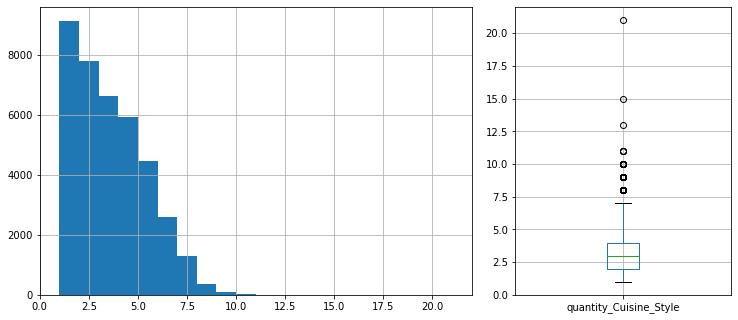

In [27]:
diagram_bar(df[df['NAN_Cuisine'] != 1], 'quantity_Cuisine_Style')

In [28]:
df.loc[(df['NAN_Cuisine'] == 1), 'quantity_Cuisine_Style'] = df.loc[(df['NAN_Cuisine'] != 1), 'quantity_Cuisine_Style'].median()

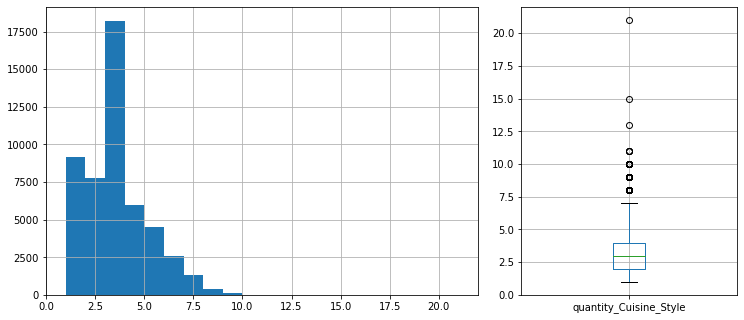

In [29]:
diagram_bar(df, 'quantity_Cuisine_Style')

Ranking

In [30]:
df.Ranking.describe()

count    50000.000000
mean      3664.427520
std       3700.092452
min          1.000000
25%        972.000000
50%       2278.000000
75%       5241.000000
max      16444.000000
Name: Ranking, dtype: float64

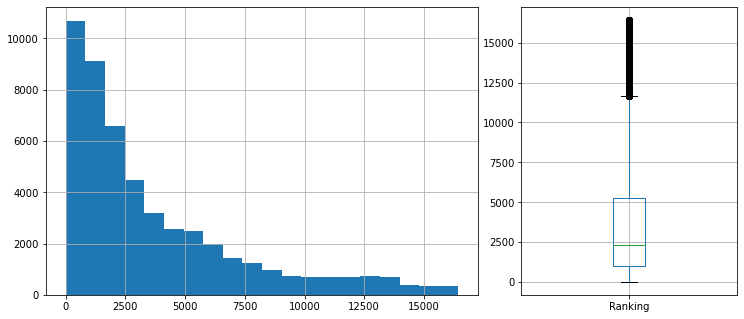

In [31]:
diagram_bar(df, 'Ranking')

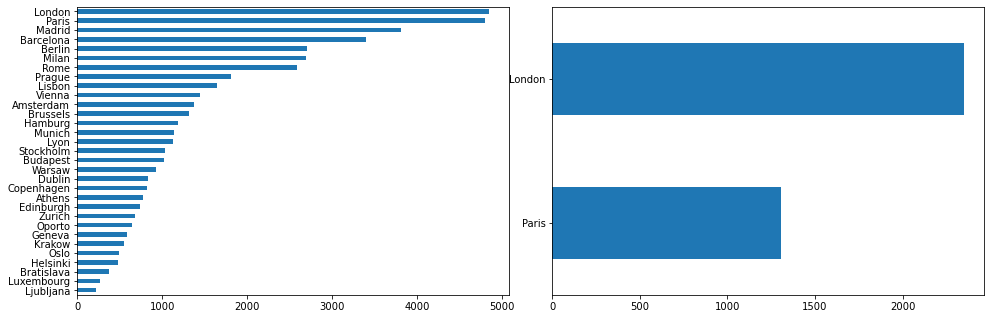

In [32]:
# большое количество выбросов. Просмотрим распеределение до 11000 и более
fig = plt.figure()
main_axes = fig.add_axes([0,0,1,1])
df[df['Ranking'] < 11000]['City'].value_counts(ascending=True).plot(kind='barh')
insert_axes = fig.add_axes([1.1,0,1,1])
df[df['Ranking'] >= 11000]['City'].value_counts(ascending=True).plot(kind='barh')

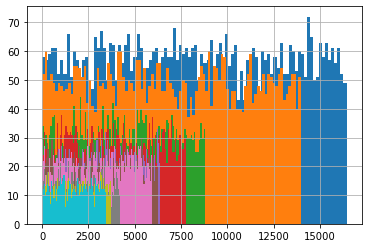

In [33]:
# Выбросы находятся в 2-х городах Лондон и Париж. Выбросы могут быть связаны с количеством заведений в городах
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

In [34]:
# Нормализуем признак Ranking

Ranking_City_mean = df.groupby(['City'])['Ranking'].mean()
Restorant_City_count = df['City'].value_counts(ascending=False)
df['Ranking_City_mean'] = df['City'].apply(lambda x: Ranking_City_mean[x])
df['Restorant_City_count'] = df['City'].apply(lambda x: Restorant_City_count[x])
df['Ranking_Rest_City_norm'] = (df['Ranking'] - df['Ranking_City_mean']) / df['Restorant_City_count']

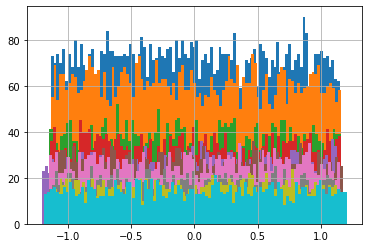

In [35]:
for x in (df['City'].value_counts())[0:10].index:
    df['Ranking_Rest_City_norm'][df['City'] == x].hist(bins=100)
plt.show()

**Вывод**

Большое значение подпадает под выбросы предлагаю ничего не делать с данными

Price Range

In [36]:
dict_Price = {'$':1,'$$ - $$$':2,'$$$$':3}
df['Price Range']=df['Price Range'].map(lambda x: dict_Price.get(x,x))

In [37]:
# для пропусков данных предлагаю заполнить пропуски модой

df['Price Range'] = df['Price Range'].fillna(2)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Restaurant_id           50000 non-null  object 
 1   City                    50000 non-null  object 
 2   Cuisine Style           50000 non-null  object 
 3   Ranking                 50000 non-null  float64
 4   Price Range             50000 non-null  float64
 5   Number of Reviews       46800 non-null  float64
 6   Reviews                 49998 non-null  object 
 7   URL_TA                  50000 non-null  object 
 8   ID_TA                   50000 non-null  object 
 9   Sample                  50000 non-null  int64  
 10  Rating                  50000 non-null  float64
 11  restaurant_chain        50000 non-null  object 
 12  City_code               50000 non-null  int64  
 13  capital                 50000 non-null  int64  
 14  Сity_population         50000 non-null

Number of Reviews 

In [39]:
df['Number of Reviews'].describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

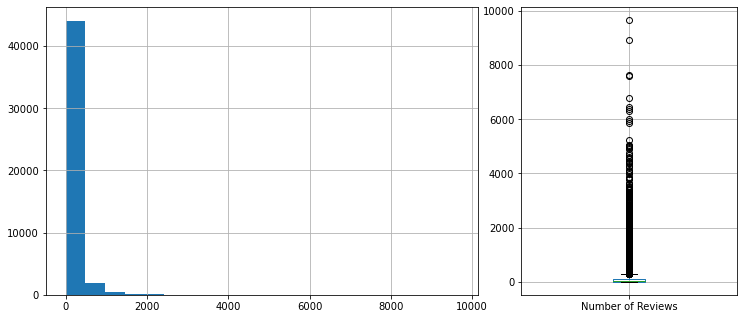

In [40]:
diagram_bar(df, 'Number of Reviews')

count    9343.000000
mean      123.050840
std       287.819368
min         2.000000
25%         9.000000
50%        32.000000
75%       114.000000
max      6437.000000
Name: Number of Reviews, dtype: float64
count    37457.000000
mean       124.825480
std        295.666352
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64


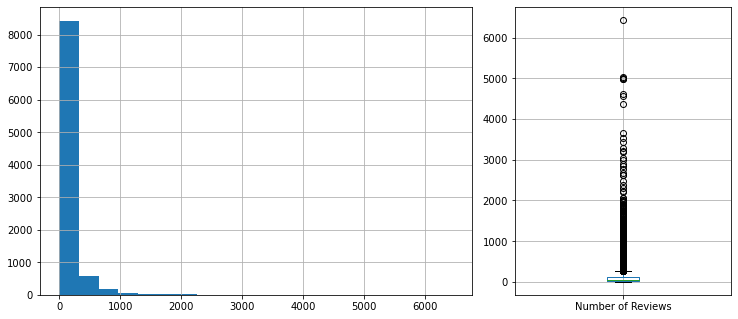

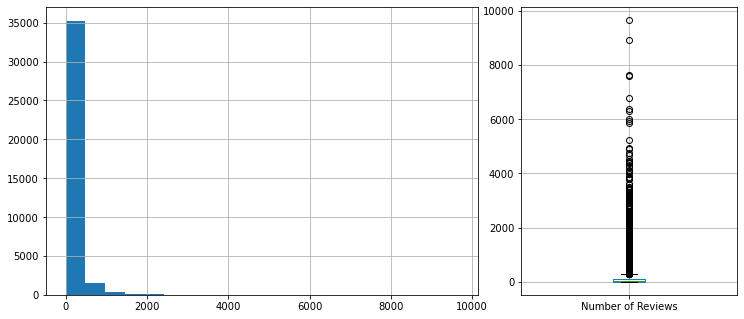

In [41]:
for element in [0,1]:
    diagram_bar(df[df['Sample'] == element], 'Number of Reviews')
    print(df[df['Sample'] == element]['Number of Reviews'].describe())

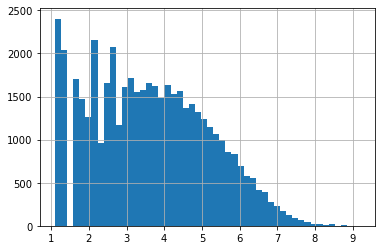

In [42]:
df['LOG_Number_Reviews'] = df['Number of Reviews'].apply(lambda x: math.log1p(x))
df['LOG_Number_Reviews'].hist(bins=50)

**Вывод**

Странный вид прологарифмированного распределения, как будто в нем два распределения причем одно логнормальное, а другое распределение Бернули

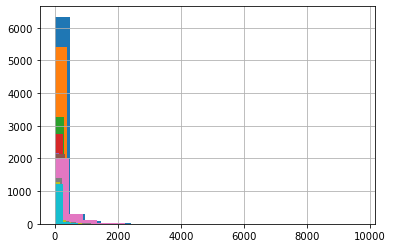

In [43]:
for x in df['City'].value_counts().index[0:10]:
    df['Number of Reviews'][df['City'] == x].hist(bins=20)
plt.show()

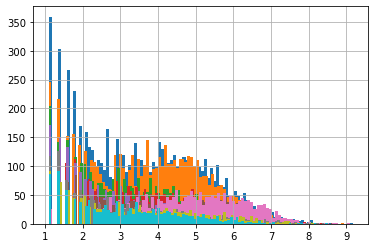

In [44]:
for x in df['City'].value_counts().index[0:10]:
    df['LOG_Number_Reviews'][df['City'] == x].hist(bins=100)
plt.show()

In [45]:
df['NAN_Number_Reviews'] = pd.isna(df['Number of Reviews']).astype('float64')

In [46]:
df['Number of Reviews'] = df['Number of Reviews'].fillna(df['Number of Reviews'].median())
df['LOG_Number_Reviews'] = df['LOG_Number_Reviews'].fillna(df['LOG_Number_Reviews'].median())

Reviews

In [47]:
# в ревью нет пропусков, но, более 6000 строк со значением [[], []]. По сути это пустые строки сохраним их 
df['empty_Reviews'] = (df['Reviews']=='[[], []]').astype('float64')

# анализ тестовой базы выявил два пропуска, несмотря на то, что pandas.profiling на тренировочной базе пропусков не выявил, заполним их '[[], []]' и закинем в empty_Reviews
df['Reviews'] = df['Reviews'].fillna('[[], []]')
df['empty_Reviews'] = (df['Reviews']=='[[], []]').astype('float64')

In [48]:
# вытащим дату из ревью и создадим новые критерии
df['date_of_Review'] = df['Reviews'].str.findall('\d+/\d+/\d+')
df['len_date'] = df['date_of_Review'].apply(lambda x: len(x))

In [49]:
df['len_date'].describe()

count    50000.000000
mean         1.561920
std          0.755577
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: len_date, dtype: float64

In [50]:
df[df['len_date']>2]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Sample,Rating,restaurant_chain,City_code,capital,Сity_population,Сity_income,Сountry,code_Сountry,NAN_Cuisine,quantity_Cuisine_Style,Ranking_City_mean,Restorant_City_count,Ranking_Rest_City_norm,LOG_Number_Reviews,NAN_Number_Reviews,empty_Reviews,date_of_Review,len_date
2221,id_2221,London,"[Lebanese, Fast Food, Mediterranean, Turkish, ...",3552.0,1.0,202.0,"[['We visited 21/10/17', 'Best Kebab in London...",/Restaurant_Review-g186338-d1009460-Reviews-Ta...,d1009460,0,0.0,1,16,1,8908,2511,England,4,0,6.0,8169.707354,7193,-0.641972,5.313206,0.0,0.0,"[21/10/17, 12/22/2017, 10/19/2017]",3
3809,id_3809,Stockholm,"[European, Swedish, Scandinavian]",956.0,2.0,9.0,"[['Good Museum Cafeteria', 'Lunch 30/5/2017'],...",/Restaurant_Review-g189852-d12318961-Reviews-N...,d12318961,0,0.0,1,27,0,961,2391,Sweden,21,0,3.0,1237.482091,1033,-0.272490,2.302585,0.0,0.0,"[30/5/2017, 04/13/2017, 05/30/2017]",3
19254,id_12965,London,"[Cafe, French]",12975.0,2.0,31.0,"[['The desserts arcade !', 'Visit today 3/1/20...",/Restaurant_Review-g186338-d1017372-Reviews-Ma...,d1017372,1,3.5,1,16,1,8908,2511,England,4,0,2.0,8169.707354,7193,0.668051,3.465736,0.0,0.0,"[3/1/2017, 06/02/2017, 01/03/2017]",3
33348,id_450,Geneva,"[French, European]",453.0,2.0,48.0,"[['lunch 29/9/2016', 'Unplanned Great Dinner']...",/Restaurant_Review-g188057-d2706773-Reviews-Le...,d2706773,1,4.0,1,10,0,201,2100,Switzerland,22,0,2.0,713.227119,590,-0.441063,3.891820,0.0,0.0,"[29/9/2016, 09/30/2016, 08/25/2016]",3


In [51]:
df.loc[df['len_date']>2]['Reviews']

2221     [['We visited 21/10/17', 'Best Kebab in London...
3809     [['Good Museum Cafeteria', 'Lunch 30/5/2017'],...
19254    [['The desserts arcade !', 'Visit today 3/1/20...
33348    [['lunch 29/9/2016', 'Unplanned Great Dinner']...
Name: Reviews, dtype: object

In [52]:
# видим что люди указывали даты в отзывах и эти даты попали в обработку. выбросим данные из DF
for row in df.loc[df['len_date']>2].index:
    date_list = df.loc[row]['date_of_Review']
    del date_list[0]
    df.loc[row]['date_of_Review'] = date_list

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [53]:
df.loc[df['len_date'] == 1]

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Sample,Rating,restaurant_chain,City_code,capital,Сity_population,Сity_income,Сountry,code_Сountry,NAN_Cuisine,quantity_Cuisine_Style,Ranking_City_mean,Restorant_City_count,Ranking_Rest_City_norm,LOG_Number_Reviews,NAN_Number_Reviews,empty_Reviews,date_of_Review,len_date
12,id_12,Munich,[Greek],1987.0,1.0,10.0,[['You always feel very Welcome at this cozy.....,/Restaurant_Review-g187309-d958943-Reviews-Wro...,d958943,0,0.0,1,21,0,1457,5181,Germany,7,0,1.0,1370.297817,1145,0.538605,2.397895,0.0,0.0,[03/20/2010],1
31,id_31,Paris,[Other],3156.0,2.0,19.0,"[['Very good food'], ['09/24/2017']]",/Restaurant_Review-g187147-d11953078-Reviews-B...,d11953078,0,0.0,1,24,1,2206,3617,France,6,1,3.0,6938.557138,6108,-0.619279,2.995732,0.0,0.0,[09/24/2017],1
48,id_48,Athens,[Greek],1077.0,2.0,3.0,"[['Thomas'], ['01/06/2016']]",/Restaurant_Review-g189400-d8747125-Reviews-Yo...,d8747125,0,0.0,1,1,1,665,1100,Greece,8,0,1.0,880.213918,776,0.253590,1.386294,0.0,0.0,[01/06/2016],1
50,id_50,Budapest,"[Italian, Pizza, Street Food]",1983.0,1.0,7.0,"[['The best in Budapest so far'], ['03/05/2017']]",/Restaurant_Review-g274887-d10788740-Reviews-P...,d10788740,0,0.0,1,6,1,1752,670,Romania,16,0,3.0,1219.061704,1021,0.748226,2.079442,0.0,0.0,[03/05/2017],1
55,id_55,Madrid,[Other],6819.0,2.0,10.0,[['Coffee was fine - and as it says low price'...,/Restaurant_Review-g187514-d11633790-Reviews-L...,d11633790,0,0.0,1,19,1,3223,2651,Spain,20,1,3.0,4388.516391,3813,0.637420,2.397895,0.0,0.0,[04/21/2017],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49972,id_2009,Prague,"[Cafe, Delicatessen, Healthy, Wine Bar, Street...",2012.0,1.0,33.0,"[['Personal expirence'], ['10/27/2017']]",/Restaurant_Review-g274707-d12981295-Reviews-M...,d12981295,1,5.0,1,25,1,1308,1400,Czech_c,2,0,5.0,2086.979626,1816,-0.041288,3.526361,1.0,0.0,[10/27/2017],1
49974,id_4650,Barcelona,[Mediterranean],4651.0,2.0,4.0,"[['Nice place to eat and chill'], ['08/29/2016']]",/Restaurant_Review-g187497-d10606787-Reviews-T...,d10606787,1,5.0,1,2,0,1620,2663,Spain,20,0,1.0,3879.422680,3395,0.227269,1.609438,0.0,0.0,[08/29/2016],1
49983,id_2487,Amsterdam,[Other],2494.0,2.0,2.0,"[['Italian food, as in Italy!'], ['05/24/2015']]",/Restaurant_Review-g188590-d8120959-Reviews-Sa...,d8120959,1,4.5,1,0,1,860,4612,Holland,9,1,3.0,1591.589650,1372,0.657733,1.098612,0.0,0.0,[05/24/2015],1
49984,id_840,Lyon,"[French, American, Cafe, Healthy, Soups]",841.0,2.0,10.0,"[['Good Cookies and more'], ['11/03/2016']]",/Restaurant_Review-g187265-d11793820-Reviews-C...,d11793820,1,5.0,1,18,0,506,2400,France,6,0,5.0,1303.902309,1126,-0.411103,2.397895,0.0,0.0,[11/03/2016],1


In [54]:
# оказалось, что есть отзывы с одним (1) отзывом и их достаточно много 5680
# поэтому предлагаю работать с одной (первой датой)
# в качестве признаков предлагаю использовать месяц и день недели наиболее свежего отзыва 

df['week_day'] = df['date_of_Review'].apply(lambda x: pd.to_datetime(x).max().weekday())
df['month'] = df['date_of_Review'].apply(lambda x: pd.to_datetime(x).max().month)


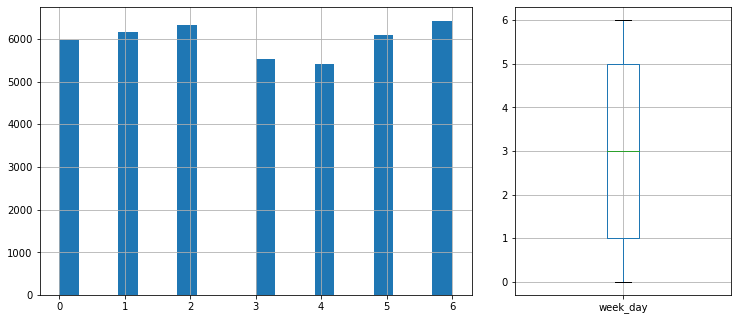

In [55]:
diagram_bar(df, 'week_day')

In [56]:
df['week_day'] = df['week_day'].fillna(df['week_day'].value_counts().index[0])

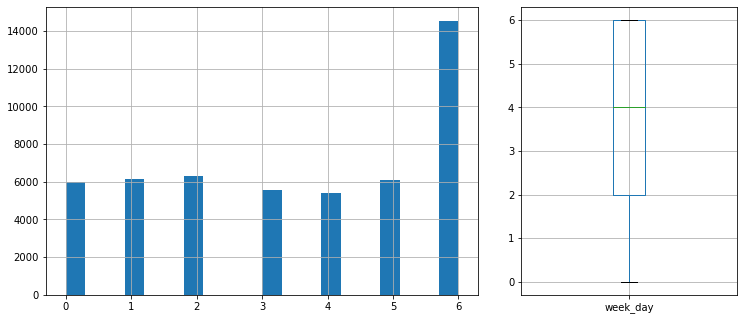

In [57]:
diagram_bar(df, 'week_day')

In [58]:
day_week = pd.get_dummies(df['week_day'])
day_week.columns = ['mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
df = pd.concat([df,day_week], axis=1)

In [59]:
for column in day_week.columns:
    print(column)
    hypothyroidism(df, column, 0.05)

mo
Отвергаем нулевую гипотезу
Tu
Отвергаем нулевую гипотезу
We
Отвергаем нулевую гипотезу
Th
Отвергаем нулевую гипотезу
Fr
Отвергаем нулевую гипотезу
Sa
Отвергаем нулевую гипотезу
Su
Отвергаем нулевую гипотезу


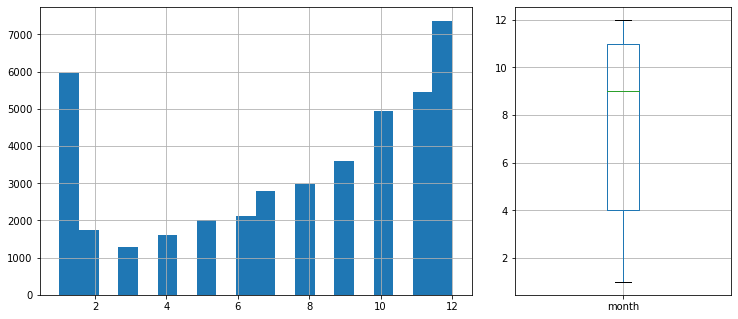

In [60]:
diagram_bar(df, 'month')

In [61]:
df['month'] = df['month'].fillna(df['month'].value_counts().index[0])

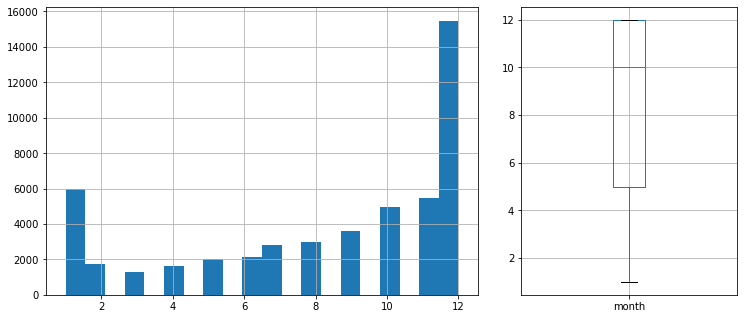

In [62]:
diagram_bar(df, 'month')

In [63]:
month = pd.get_dummies(df['month'])
month.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
df = pd.concat([df,month], axis=1)

In [64]:
for column in month.columns:
    print(column)
    hypothyroidism(df, column, 0.05)

Jan
Отвергаем нулевую гипотезу
Feb
Отвергаем нулевую гипотезу
Mar
Отвергаем нулевую гипотезу
Apr
Отвергаем нулевую гипотезу
May
Отвергаем нулевую гипотезу
June
Отвергаем нулевую гипотезу
July
Отвергаем нулевую гипотезу
Aug
Отвергаем нулевую гипотезу
Sept
Отвергаем нулевую гипотезу
Oct
Отвергаем нулевую гипотезу
Nov
Отвергаем нулевую гипотезу
Dec
Отвергаем нулевую гипотезу


In [65]:
#введем новые признаки разница между датами, и срок давности 

def delta_data(data):
    if data['date_of_Review'] == []:
        return None
    return pd.to_datetime(data['date_of_Review']).max() - pd.to_datetime(data['date_of_Review']).min()

def delta_data_now(data):
    if data['date_of_Review'] == []:
        return None
    return datetime.datetime.now() - pd.to_datetime(data['date_of_Review']).max()

In [66]:
df['delta_data'] = df.apply(delta_data, axis = 1).dt.days
df['delta_data_now'] = df.apply(delta_data_now, axis = 1).dt.days

In [67]:
df['LEN_Reviews'] = df['Reviews'].apply(lambda x: len(x))

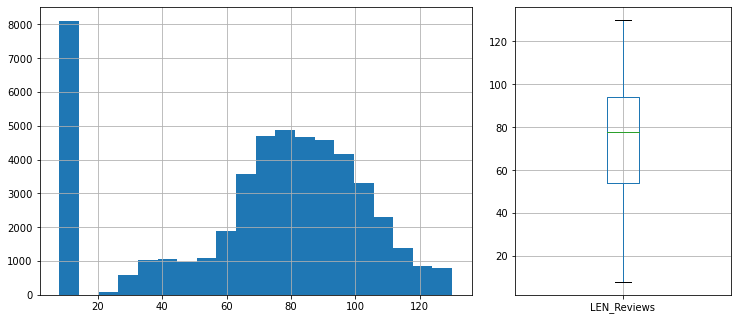

In [68]:
diagram_bar(df, 'LEN_Reviews')

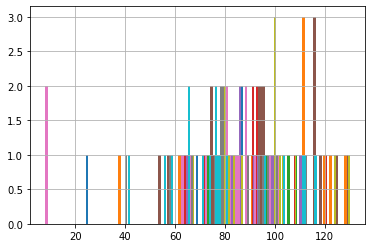

In [69]:
for x in df['Restaurant_id'].value_counts().index[0:10]:
    df['LEN_Reviews'][df['Restaurant_id'] == x].hist(bins=100)
plt.show()

**Шаг 5.** Отберем необходимые факторы в модель.

In [70]:
df.drop(['Restaurant_id', 'City', 'Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA', 'date_of_Review', 'Сountry', 'Сity_population', 'mean_Ranking_on_City', 'count_Restorant_in_City', 'max_Ranking_on_City'], axis=1, inplace=True, errors='ignore')
df_model = df

In [71]:
display(df_model.describe())

,Ranking,Number of Reviews,Sample,Rating,City_code,capital,Сity_income,code_Сountry,NAN_Cuisine,quantity_Cuisine_Style,Ranking_City_mean,Restorant_City_count,Ranking_Rest_City_norm,LOG_Number_Reviews,NAN_Number_Reviews,empty_Reviews,len_date,week_day,month,mo,Tu,We,Th,Fr,Sa,Su,Jan,Feb,Mar,Apr,May,June,July,Aug,Sept,Oct,Nov,Dec,delta_data,delta_data_now,LEN_Reviews
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.00000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,41886.000000,41886.000000,50000.000000
mean,3664.427520,118.617040,0.800000,3.194430,15.955640,0.752700,2977.557460,10.014760,0.231800,3.088920,3664.427520,3196.634400,-5.211387e-18,3.595321,0.064000,0.162280,1.561920,3.493180,8.272280,0.119320,0.123060,0.126420,0.110740,0.108060,0.121580,0.290820,0.119260,0.035060,0.02574,0.03218,0.04020,0.042620,0.055680,0.05950,0.071820,0.098960,0.109260,0.309720,123.218331,1233.045361,69.956820
std,3700.092452,285.426269,0.400004,1.705453,8.682093,0.431447,1186.815254,6.449897,0.421986,1.591334,2623.722828,2321.787321,6.674963e-01,1.514872,0.244755,0.368711,0.755577,2.158974,3.896784,0.324168,0.328509,0.332325,0.313813,0.310459,0.326803,0.454145,0.324097,0.183933,0.15836,0.17648,0.19643,0.202001,0.229305,0.23656,0.258192,0.298611,0.311968,0.462383,212.592518,363.252094,33.453345
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,670.000000,0.000000,0.000000,1.000000,234.509009,222.000000,-1.209024e+00,1.098612,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,943.000000,8.000000
25%,972.000000,10.000000,1.000000,3.000000,8.000000,1.000000,2511.000000,4.000000,0.000000,2.000000,1370.297817,1145.000000,-5.776474e-01,2.397895,0.000000,0.000000,1.000000,2.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,8.000000,1022.000000,54.000000
50%,2278.000000,33.000000,1.000000,4.000000,16.000000,1.000000,2663.000000,7.000000,0.000000,3.000000,3106.027840,2694.000000,-4.143651e-03,3.526361,0.000000,0.000000,2.000000,4.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,49.000000,1096.000000,78.000000
75%,5241.000000,105.000000,1.000000,4.500000,24.000000,1.000000,3617.000000,15.000000,0.000000,4.000000,6938.557138,6108.000000,5.762193e-01,4.663439,0.000000,0.000000,2.000000,6.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,148.000000,1280.000000,94.000000
max,16444.000000,9660.000000,1.000000,5.000000,30.000000,1.000000,6758.000000,22.000000,1.000000,21.000000,8169.707354,7193.000000,1.216334e+00,9.175852,1.000000,1.000000,3.000000,6.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,3296.000000,6002.000000,130.000000


In [72]:
#стандартизируем два столбца Ranking, City_code

def StandardScaler_column(d_col):
    scaler = StandardScaler()
    scaler.fit(df_model[[d_col]])
    return scaler.transform(df_model[[d_col]])

for column in df_model.columns:
    if column not in ['Rating','Sample']:
        df_model[column] = StandardScaler_column(column)
        if len(df_model[df_model[column].isna()]) < len(df_model):
            df_model[column] = df_model[column].fillna(0)
    


**Шаг 6.** Разбиваем df_model на обучающей и тестовый и проверяем тренировочную выборку

In [73]:
train_data = df_model.query('Sample == 1').drop(['Sample'], axis=1)
test_data = df_model.query('Sample == 0').drop(['Sample'], axis=1)

In [74]:
# Проверяем модель на обучающей выборке

y = train_data.Rating.values            
X = train_data.drop(['Rating'], axis=1)

# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [75]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 41), (40000, 41), (40000, 40), (32000, 40), (8000, 40))

In [76]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [77]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [78]:
# функция стандартного математического округления
def classic_round(d_num):
    return int(d_num + (0.5 if d_num > 0 else -0.5))

# функция округления кратно 0.5
def my_round(d_pred):
    result = classic_round(d_pred*2)/2
    if result <=5:
        return result
    else:
        return 5
    
# создание функции для векторов np
my_vec_round = np.vectorize(my_round)

In [79]:
y_pred = my_vec_round(y_pred)

In [80]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
MAE = metrics.mean_absolute_error(y_test, y_pred)
print('MAE:', MAE)

MAE: 0.1739375


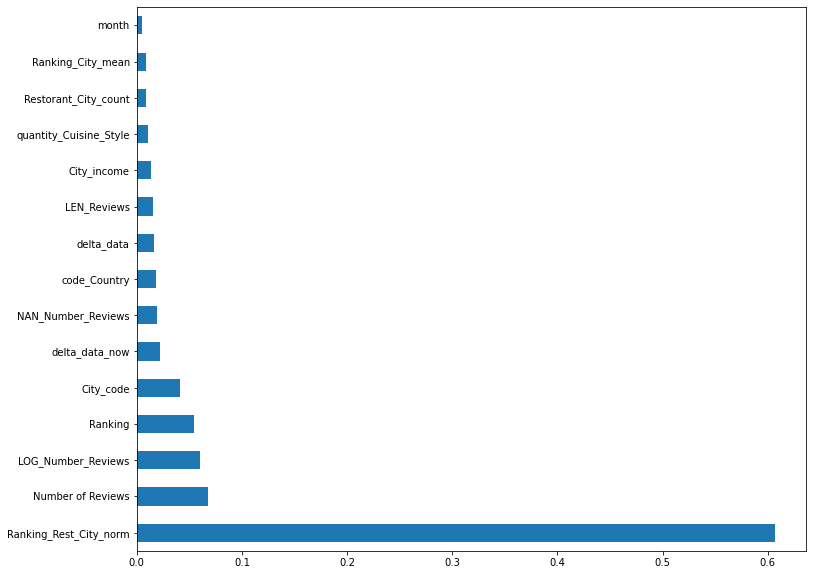

In [81]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (12,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

(15.5, -0.5)

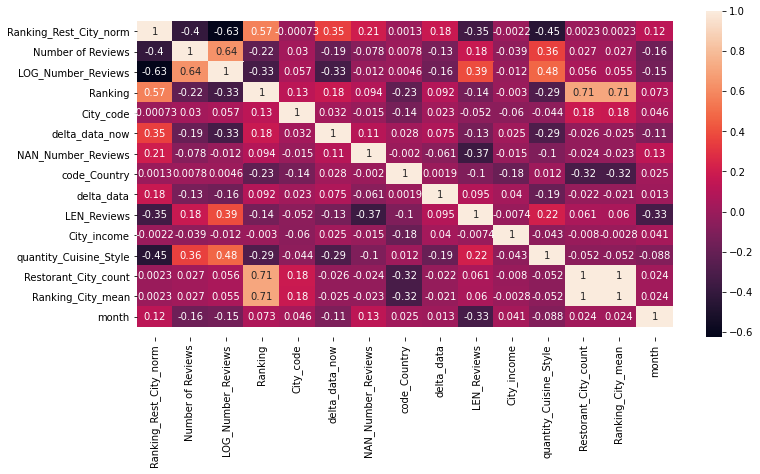

In [82]:
#Проверяем корреляцию важных переменных и применяем метод главных компонент (PCA)

df_temp = df_model.loc[df_model['Sample'] == 1, list(feat_importances.nlargest(15).index[0:15])]
plt.rcParams['figure.figsize'] = (12,6)
ax = sns.heatmap(df_temp.corr(), annot=True, fmt='.2g')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

In [83]:
list_temp = list(feat_importances.nlargest(15).index[[11,12]])
display(df_temp[list_temp].corr())

,quantity_Cuisine_Style,Restorant_City_count
quantity_Cuisine_Style,1.000000,-0.051799
Restorant_City_count,-0.051799,1.000000


In [84]:
df_model.drop(['Ranking_City_mean'], axis=1, inplace=True, errors='ignore')

In [85]:
train_data = df.query('Sample == 1').drop(['Sample'], axis=1)
test_data = df.query('Sample == 0').drop(['Sample','Rating'], axis=1)

In [86]:
y = train_data.Rating.values    
X = train_data.drop(['Rating'], axis=1)

In [87]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [88]:
model.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.4s finished


RandomForestRegressor(n_jobs=-1, random_state=42, verbose=1)

In [89]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [90]:
predict_submission = my_vec_round(predict_submission)

In [91]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5
